## Домашнее задание к Уроку 4

#### Импортируем необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd; pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
from IPython import display
from IPython.display import Image

In [2]:
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

In [5]:
from catboost import CatBoostClassifier
from sklift.models import SoloModel
from sklift.models import ClassTransformation
from sklift.models import TwoModels

### Домашнее задание

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

#### Загружаем данные

In [6]:
df = pd.read_csv('data.csv')

#### Описание данных

Данные содержат следующие признаки:
    
    1. recency - количество месяцев с момента последней покупки
    2. history - история стоимости всех покупок в долларах
    3. used_discount - указывает на то что клиент использовал/неиспользовал скидку ранее
    4. used_bogo - укаазывает на то что клиент использовал возможность поления товара до оплаты
    5. zip_code - класс почтового индекса (областной / городской / сельский)
    6. is_referral - указывает, был ли клиент привлечен по реферальному каналу (через отзовы или рекоммендации других клиентов)
    7. channel - канал который использует клиент (Телефон, Web, множество каналов)
    8. offer - предложение предоставленое клинту в рамках коммуникации (Скидка, Получение товара до оплаты, небыло предложений)
    9. conversion - конверсия в купил/не купил (целевой признак)

#### Предварительный обзор данных

In [7]:
df.head(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


Пропуски в наборе данных отсутствуют. 

In [9]:
df.describe()

,recency,history,used_discount,used_bogo,is_referral,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000


#### Преобразование данных

In [10]:
# Переименуем индекс как id клиента
df.index.rename('Client_ID', inplace=True)
# Переименуем признак conversion в target
df.rename(columns = {'conversion' :'target'}, inplace = True)

In [11]:
treatment_dict = {'No Offer': 0, 'Buy One Get One': 1, 'Discount': 1}
# Сформируем признак treatment как бинарный вариант признака offer а offer удалим
df['treatment'] = df['offer'].map(treatment_dict).astype(int)
df = df.drop('offer', axis=1)

In [12]:
df['treatment'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 64000 entries, 0 to 63999
Series name: treatment
Non-Null Count  Dtype
--------------  -----
64000 non-null  int32
dtypes: int32(1)
memory usage: 250.1 KB


In [13]:
# Сохраним список категориальных признаков после предобработки
cat_features = ['zip_code', 'channel']

In [14]:
#приведем признаки в правилбную последовательность
df = df.reindex(columns=['recency', 'history', 'used_discount', 'used_bogo', 'zip_code',
                         'is_referral', 'channel', 'treatment', 'target'])

In [15]:
df.head(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
Client_ID,,,,,,,,,
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


#### Подготвка и разбиение датасетов

In [16]:
X = df[['recency', 'history', 'used_discount', 'used_bogo', 'zip_code', 'is_referral', 'channel']]
y = pd.Series(df['target'])
treat = pd.DataFrame(df['treatment'])

In [17]:
# Разабьем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [18]:
# Теперь разобьем обучающую выборку на обучающую и валидационную
X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=1)
# Выдилим отдельно бинарный признак коммуникации с клиентов в валидационную выборку
treat_train = treat.loc[X_train_val.index, 'treatment']
treat_val = treat.loc[X_val.index, 'treatment']

In [19]:
treat_train = treat_train.squeeze()
treat_val = treat_val.squeeze()

In [20]:
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': [],
    'avg_uplift': []
}

#### Модель с признаком коммуникации

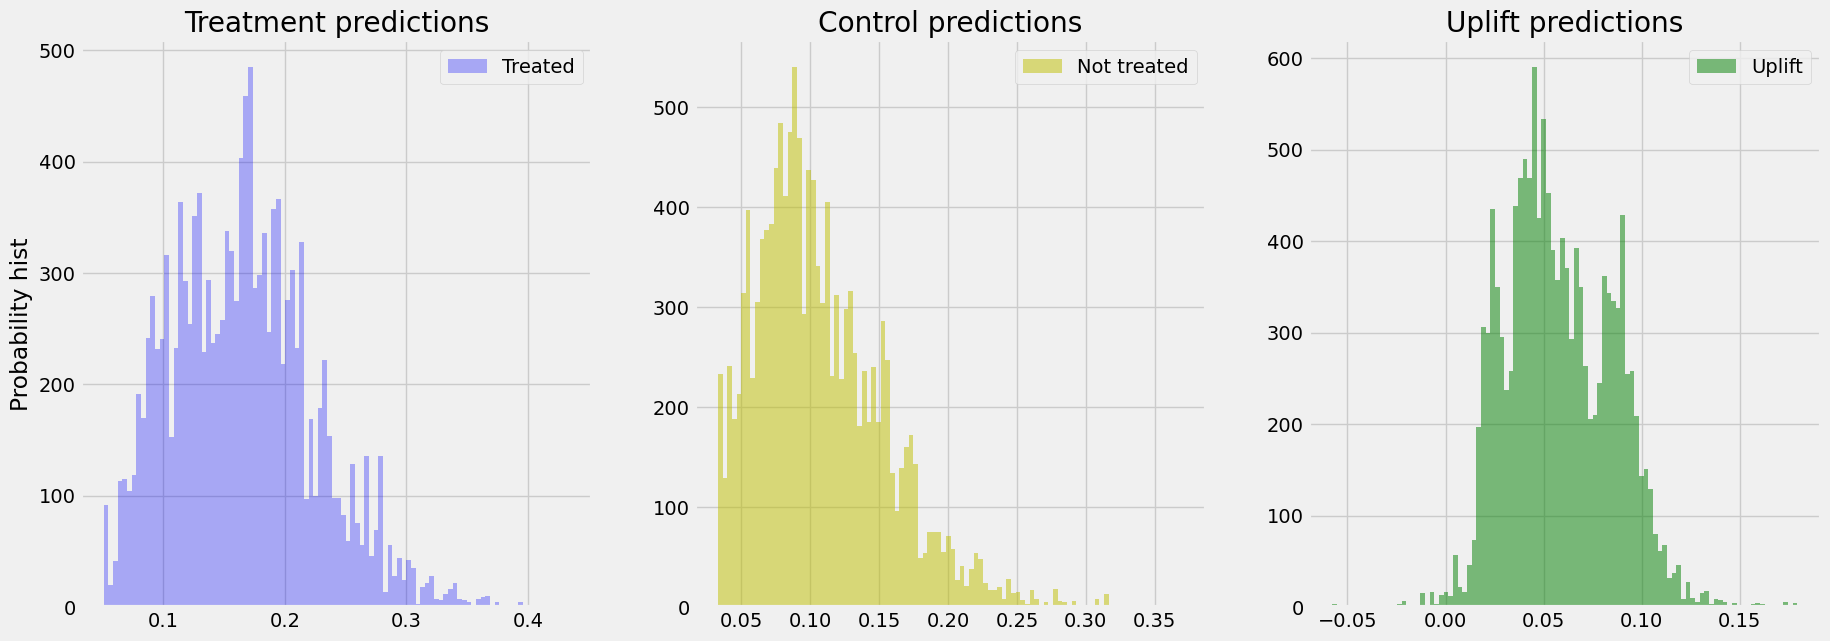

In [21]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train_val, y_train_val, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)
models_results['avg_uplift'].append((sm_score_10 + sm_score_20)/2)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [22]:
# Посмотрим на важность признаков в моделе:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,19.966327
1,treatment,19.927630
2,history,13.150558
3,recency,12.300663
4,zip_code,10.565132
5,used_bogo,9.122417
6,channel,8.341084
7,used_discount,6.626188


#### Модель с Трансформацией классов

In [23]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train_val, y_train_val, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)
models_results['avg_uplift'].append((ct_score_10 + ct_score_20)/2)

In [24]:
# Посмотрим на важность признаков в моделе:
ct_fi = pd.DataFrame({
    'feature_name': ct.estimator.feature_names_,
    'feature_score': ct.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

ct_fi

,feature_name,feature_score
0,history,27.787908
1,is_referral,18.169691
2,recency,18.156589
3,used_bogo,15.095692
4,used_discount,11.364490
5,channel,5.101157
6,zip_code,4.324472


#### Две независимые модели

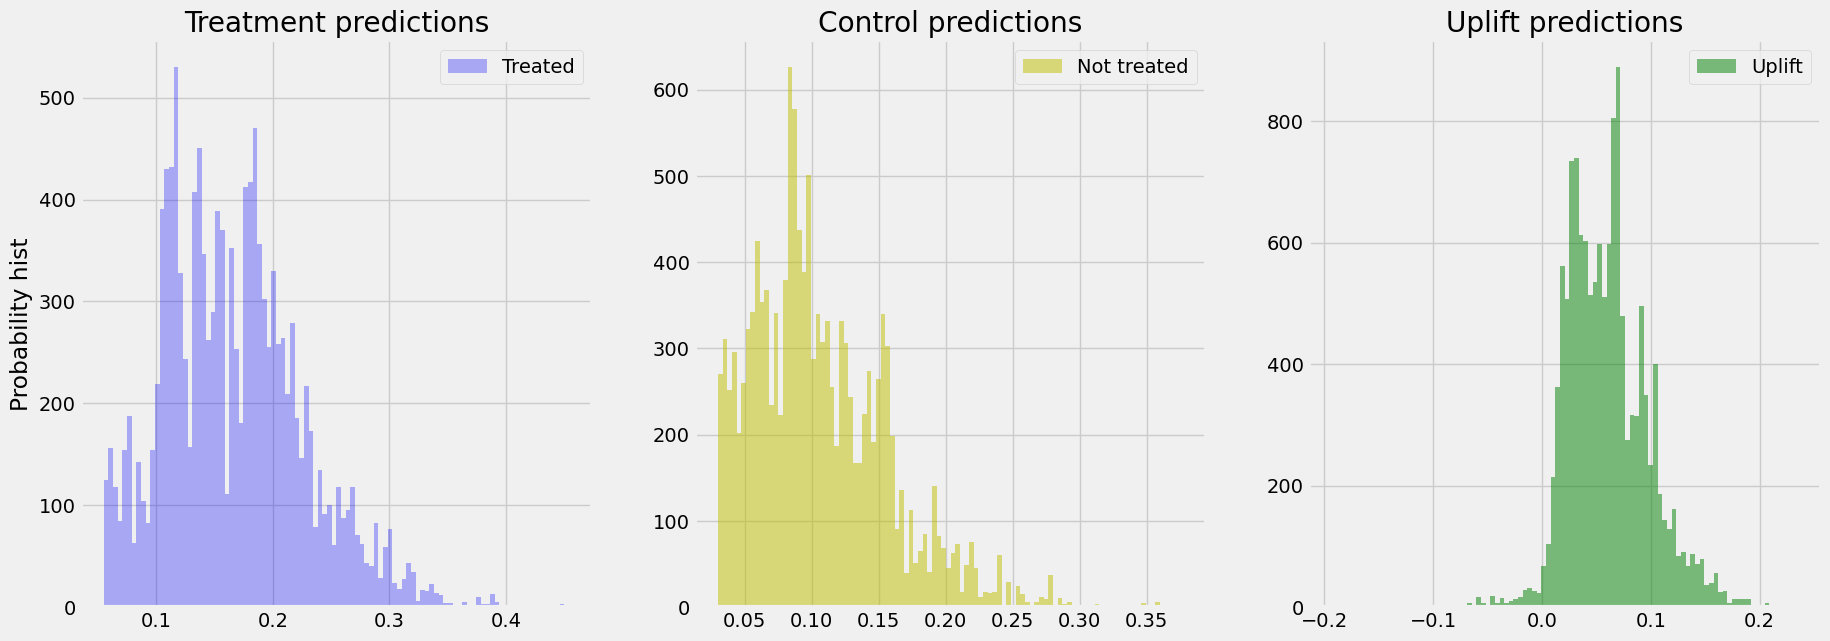

In [25]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train_val, y_train_val, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)
models_results['avg_uplift'].append((tm_score_10 + tm_score_20)/2)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

#### Посмотрим на результаты

In [26]:
pd.DataFrame(data=models_results).sort_values('avg_uplift', ascending=False)

,approach,uplift@10%,uplift@20%,avg_uplift
1,ClassTransformation,0.082131,0.082046,0.082088
2,TwoModels,0.086869,0.070605,0.078737
0,SoloModel,0.062367,0.067257,0.064812


#### Вывод

Наилучшей выглядит модель Class Transformation

#### Вариант с случайным лесом

In [27]:
X_train_tree = pd.concat([X_train_val.drop(['zip_code', 'channel'], 1), 
                          pd.get_dummies(X_train_val['zip_code'], prefix='zip_code'),
                          pd.get_dummies(X_train_val['channel'], prefix='channel')], 1)
features = [col for col in X_train_tree]

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.


In [28]:
X_train_tree.head(5)

,recency,history,used_discount,used_bogo,is_referral,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
Client_ID,,,,,,,,,,,
31203,8,368.00,1,1,1,0,0,1,0,1,0
36152,4,826.07,0,1,1,0,1,0,0,0,1
42250,7,156.66,1,0,1,0,1,0,0,1,0
58124,3,57.56,0,1,1,0,1,0,0,1,0
8605,6,198.39,0,1,0,1,0,0,0,0,1


In [29]:
%%time

uplift_model = UpliftRandomForestClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(np.array(X_train_tree.values),
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train_val.values)

Wall time: 11.7 s


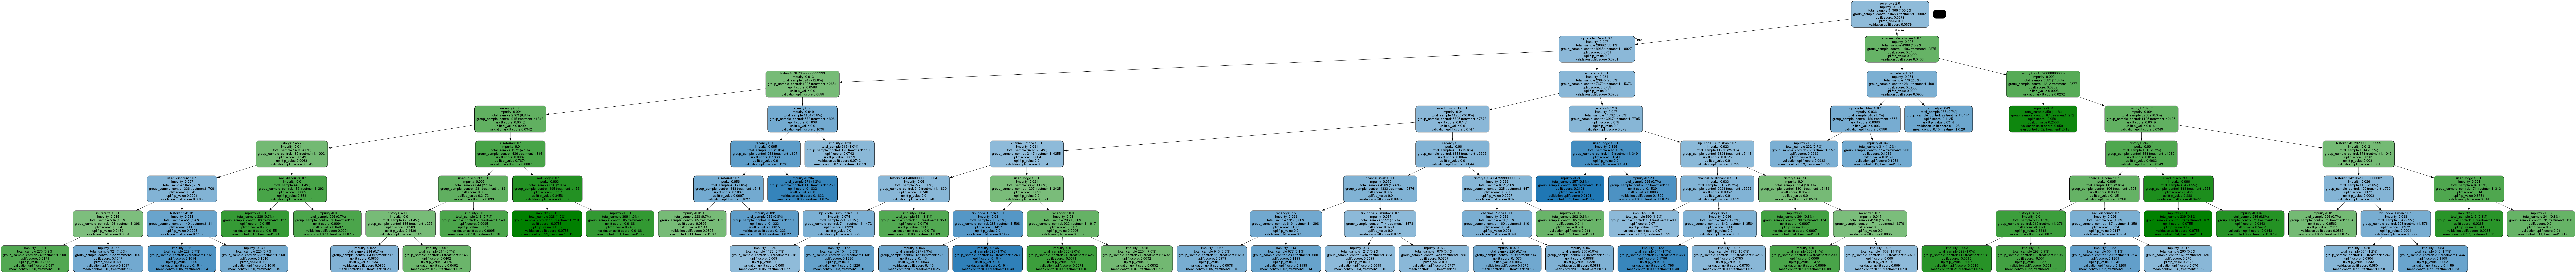

In [30]:
graph_tree = uplift_tree_plot(uplift_model.uplift_forest[0].fitted_uplift_tree, features)
Image(graph_tree.create_png())